# 📦 Decision Trees and Ensemble Methods from Scratch


In [ ]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import RegressorMixin
import src.utils as utils

# 🌱 Baseline: Decision Tree Classifier (Scikit-learn)

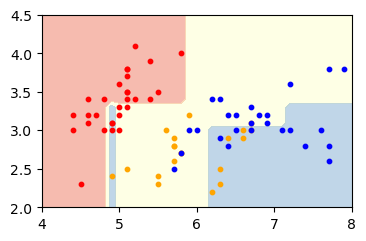

In [ ]:
# Create directories for saving figures
os.makedirs("plots", exist_ok=True)

# Load and simplify Iris dataset (2 features for 2D visualization)
iris = sklearn.datasets.load_iris()
X, T = iris.data[:, :2], iris.target

# Train/test split
(Xtrain, Ttrain), (Xtest, Ttest) = utils.split(X, T)

# Train single decision tree
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(Xtrain, Ttrain)

# Visualize decision boundary
utils.plot_iris(Xtest, Ttest, classifier.predict, None)

# 🌲 Custom Random Forest Classifier (from scratch)

In [ ]:
class RandomForestClassifier:
    def __init__(self, n_trees=100, max_depth=5):
        self.trees = [sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
                      for _ in range(n_trees)]

    def fit(self, X, y):
        for i, tree in enumerate(self.trees):
            X_sub, y_sub = utils.split(X, y, seed=i)[0]
            tree.fit(X_sub, y_sub)

    def predict(self, X):
        # One-hot encode predictions and sum votes
        predictions = np.zeros((X.shape[0], 3))
        for tree in self.trees:
            predictions += np.eye(3)[tree.predict(X)]
        return np.argmax(predictions, axis=1)

# 🌳 Random Forest Classifier vs Decision Tree: Visual Comparison

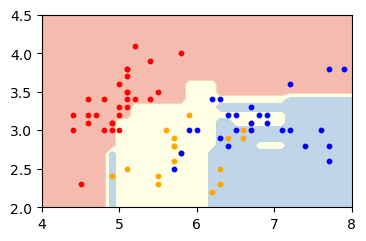

In [ ]:
cl = RandomForestClassifier(n_trees=100, max_depth=5)

(Xtrain, Ttrain), (Xtest, Ttest) = utils.split(X, T)
cl.fit(Xtrain, Ttrain)

# Visualize ensemble decision boundary
utils.plot_iris(Xtest, Ttest, cl.predict)

# 📊 Accuracy Comparison: Decision Tree vs Random Forest

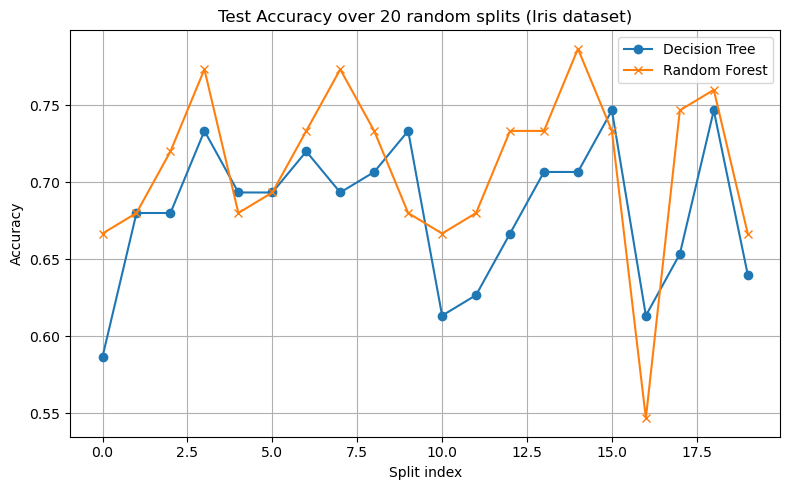

In [ ]:
tree_acc = []
forest_acc = []

for seed in range(20):
    (Xtrain, Ttrain), (Xtest, Ttest) = utils.split(X, T, seed=seed)

    # Decision tree
    tree = sklearn.tree.DecisionTreeClassifier(max_depth=5)
    tree.fit(Xtrain, Ttrain)
    preds_tree = tree.predict(Xtest)
    tree_acc.append(accuracy_score(Ttest, preds_tree))

    # Random forest
    forest = RandomForestClassifier(n_trees=100, max_depth=5)
    forest.fit(Xtrain, Ttrain)
    preds_forest = forest.predict(Xtest)
    forest_acc.append(accuracy_score(Ttest, preds_forest))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(tree_acc, label="Decision Tree", marker='o')
plt.plot(forest_acc, label="Random Forest", marker='x')
plt.title("Test Accuracy over 20 random splits (Iris dataset)")
plt.xlabel("Split index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/tree_vs_forest.png")
plt.show()

# 🌲 Random Forest Classifier (from scratch)
This section implements a simple Random Forest classifier from scratch using `scikit-learn`’s DecisionTreeClassifier as base learners. Unlike a single decision tree, which tends to overfit, the forest uses ensemble voting across 100 trees trained on random data subsets (bootstrap sampling).

In [ ]:
class RandomForestClassifier:
    def __init__(self, n_trees=100, max_depth=5):
        self.trees = [
            sklearn.tree.DecisionTreeClassifier(max_depth=max_depth)
            for _ in range(n_trees)
        ]

    def fit(self, X, y):
        for i, tree in enumerate(self.trees):
            X_sub, y_sub = utils.split(X, y, seed=i)[0]
            tree.fit(X_sub, y_sub)

    def predict(self, X):
        # One-hot encode predictions and take majority vote
        preds = sum(np.eye(3)[tree.predict(X)] for tree in self.trees)
        return np.argmax(preds, axis=1)

# 🧪 Visual comparison on the Iris dataset

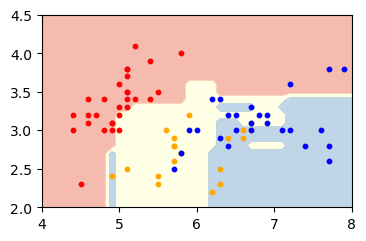

In [ ]:
(Xtrain, Ttrain), (Xtest, Ttest) = utils.split(X, T)

forest = RandomForestClassifier(n_trees=100, max_depth=5)
forest.fit(Xtrain, Ttrain)

# Save decision boundary plot
utils.plot_iris(Xtest, Ttest, forest.predict, filename="plots/random_forest_boundary.png")

# 📈 Tree Depth vs Model Performance (Regression)
To study the relationship between model complexity and generalization, we evaluate decision trees on two regression datasets: `bodyfat` and `diabetes`. Each model is evaluated using 100 different train/test splits. The metric used is the coefficient of determination (R²).

### Dataset: `bodyfat`

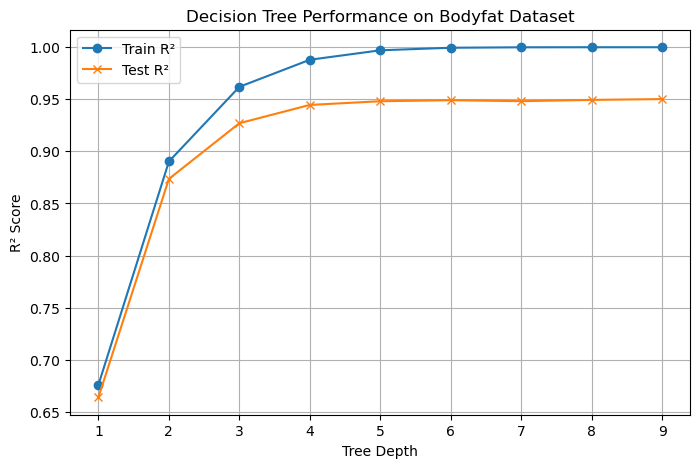

In [ ]:
# Load datasets
bodyfat  = sklearn.datasets.fetch_openml(name="bodyfat", version=1)
diabetes = sklearn.datasets.load_diabetes()

depths = list(range(1, 10))
train_scores, test_scores = [], []

for d in depths:
    reg = sklearn.tree.DecisionTreeRegressor(max_depth=d)
    strain, stest = utils.benchmark(reg, bodyfat)
    train_scores.append(strain)
    test_scores.append(stest)

plt.figure(figsize=(8,5))
plt.plot(depths, train_scores, label="Train R²", marker="o")
plt.plot(depths, test_scores, label="Test R²", marker="x")
plt.title("Decision Tree Performance on Bodyfat Dataset")
plt.xlabel("Tree Depth")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.savefig("plots/bodyfat_tree_depth_vs_r2.png")

### Dataset: diabetes

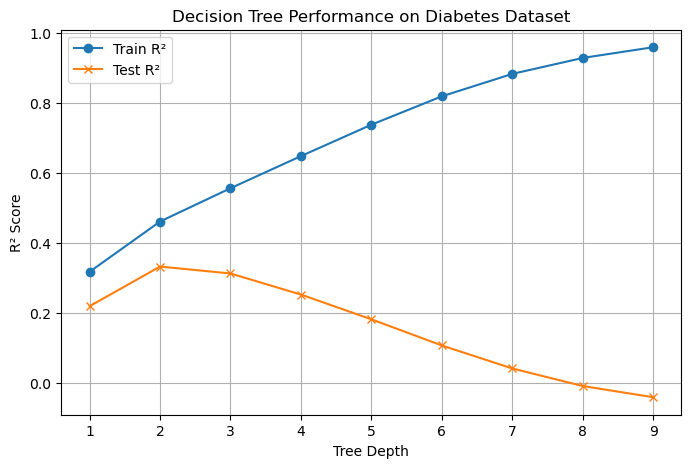

In [ ]:
train_scores, test_scores = [], []

for d in depths:
    reg = sklearn.tree.DecisionTreeRegressor(max_depth=d)
    strain, stest = utils.benchmark(reg, diabetes)
    train_scores.append(strain)
    test_scores.append(stest)

plt.figure(figsize=(8,5))
plt.plot(depths, train_scores, label="Train R²", marker="o")
plt.plot(depths, test_scores, label="Test R²", marker="x")
plt.title("Decision Tree Performance on Diabetes Dataset")
plt.xlabel("Tree Depth")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.savefig("plots/diabetes_tree_depth_vs_r2.png")

As shown above, the bodyfat dataset benefits from deeper trees, while the diabetes dataset exhibits strong overfitting beyond depth 2. This highlights the bias-variance trade-off in decision trees.

# 🌲 Random Forest Regressor (from scratch)
This implementation uses ensembling of decision trees trained on random subsets of the data, with predictions averaged across all trees. The class below mimics `scikit-learn` API and includes `score()` from `RegressorMixin`.

In [ ]:
class RandomForestRegressor(RegressorMixin):
    def __init__(self, max_depth=None, nb_trees=10):
        self.trees = [
            sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)
            for _ in range(nb_trees)
        ]

    def fit(self, X, y):
        for i, tree in enumerate(self.trees):
            X_sub, y_sub = utils.split(X, y, seed=i)[0]
            tree.fit(X_sub, y_sub)

    def predict(self, X):
        predictions = [tree.predict(X) for tree in self.trees]
        return np.mean(predictions, axis=0)

# 📊 Performance on Bodyfat Dataset
We compare a baseline decision tree (depth=7) with random forests of increasing size, using R² score on 100-fold train/test splits.

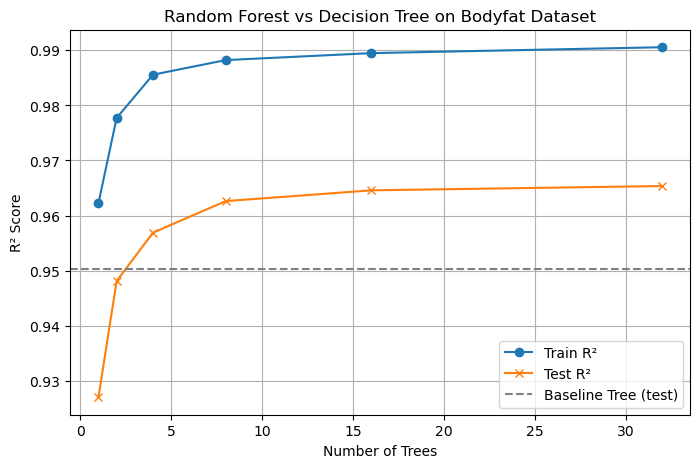

In [ ]:
nb_trees_list = [1, 2, 4, 8, 16, 32]
train_scores, test_scores = [], []

# Baseline decision tree
baseline = sklearn.tree.DecisionTreeRegressor(max_depth=7)
baseline_train, baseline_test = utils.benchmark(baseline, bodyfat)

# Random forest regressors
for nb in nb_trees_list:
    forest = RandomForestRegressor(max_depth=9, nb_trees=nb)
    strain, stest = utils.benchmark(forest, bodyfat)
    train_scores.append(strain)
    test_scores.append(stest)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(nb_trees_list, train_scores, label="Train R²", marker='o')
plt.plot(nb_trees_list, test_scores, label="Test R²", marker='x')
plt.axhline(baseline_test, linestyle='--', color='gray', label="Baseline Tree (test)")
plt.title("Random Forest vs Decision Tree on Bodyfat Dataset")
plt.xlabel("Number of Trees")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.savefig("plots/random_forest_regressor_bodyfat.png")

# 🚀 Simple Boosted Tree Regressor (from scratch)
This is a minimal implementation of gradient boosting, where each new tree is trained to predict the residual error of the current model. Small trees are used as weak learners, and their predictions are summed to form the final output.

In [14]:
class SimpleBoostedTreeRegressor(RegressorMixin):
    def __init__(self, max_depth=None, nb_trees=10):
        self.trees = [
            sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)
            for _ in range(nb_trees)
        ]

    def fit(self, X, y):
        residual = y.copy()
        for tree in self.trees:
            tree.fit(X, residual)
            residual -= tree.predict(X)

    def predict(self, X):
        return np.sum([tree.predict(X) for tree in self.trees], axis=0)

# 📊 Performance on the Diabetes Dataset
We compare the baseline decision tree (depth=2) with boosted models of increasing size (depth=1). Boosting can often outperform a strong tree using a series of weak ones.

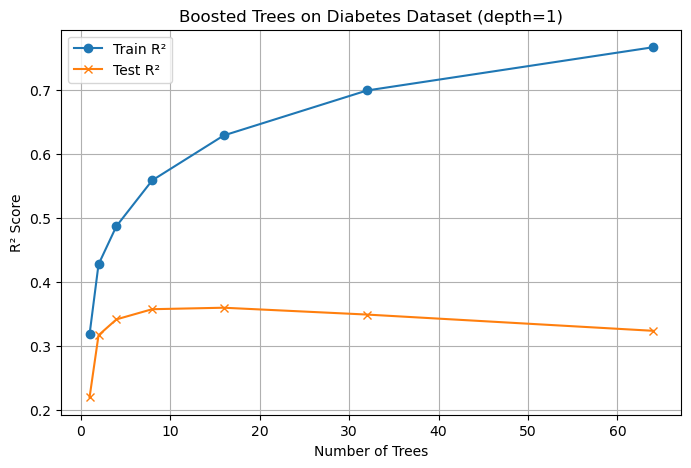

In [15]:
nb_trees_list = [1, 2, 4, 8, 16, 32, 64]
train_scores, test_scores = [], []

for nb in nb_trees_list:
    reg = SimpleBoostedTreeRegressor(max_depth=1, nb_trees=nb)
    strain, stest = utils.benchmark(reg, diabetes)
    train_scores.append(strain)
    test_scores.append(stest)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(nb_trees_list, train_scores, label="Train R²", marker="o")
plt.plot(nb_trees_list, test_scores, label="Test R²", marker="x")
plt.title("Boosted Trees on Diabetes Dataset (depth=1)")
plt.xlabel("Number of Trees")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.savefig("plots/boosted_regressor_diabetes.png")

Boosting improves generalization until ~16 trees. After that, the model may start to overfit due to error correction overshooting.

# 🧠 Depth Sensitivity Across Models
Let’s compare how tree depth affects generalization for decision trees, random forests, and boosting on two datasets.

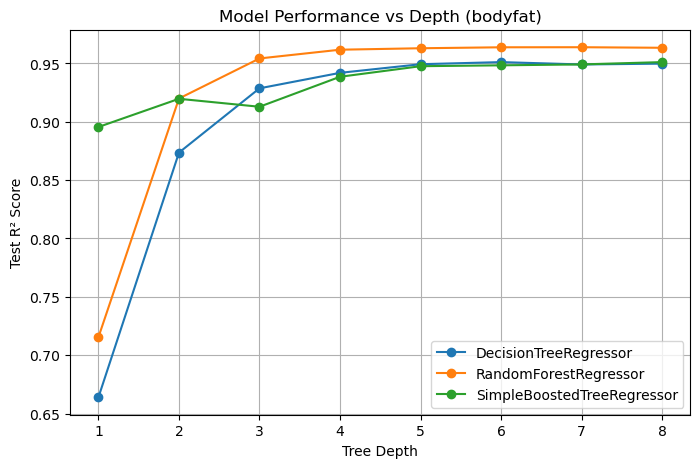

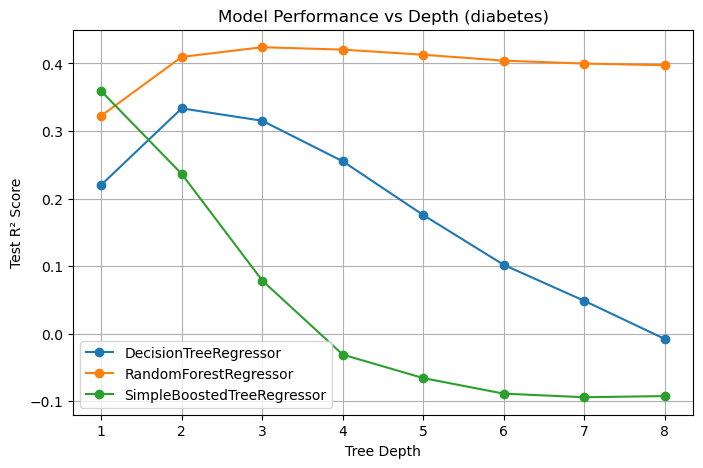

In [16]:
depths = range(1, 9)
datasets = [bodyfat, diabetes]
names = ['bodyfat', 'diabetes']
algorithms = [
    sklearn.tree.DecisionTreeRegressor,
    RandomForestRegressor,
    SimpleBoostedTreeRegressor
]

for dataset, name in zip(datasets, names):
    plt.figure(figsize=(8,5))
    plt.title(f"Model Performance vs Depth ({name})")

    for algorithm in algorithms:
        test_scores = [
            utils.benchmark(algorithm(max_depth=d), dataset)[1]
            for d in depths
        ]
        plt.plot(depths, test_scores, marker='o', label=algorithm.__name__)

    plt.xlabel("Tree Depth")
    plt.ylabel("Test R² Score")
    plt.grid(True)
    plt.legend()
    plt.savefig(f"plots/depth_vs_r2_{name}.png")

As shown, random forests tolerate deeper trees due to averaging, while boosting performs best with shallow ones. Decision trees tend to overfit past optimal depth.